In [50]:
import ai2thor
import copy
import time
import random
import ai2thor.controller
from datetime import datetime
import cv2
import os
import matplotlib.pyplot as plt
import os
import numpy as np
# from utils.mid_level_constants import  scene_start_cheating_init_pose
from jupyter_helper import ENV_ARGS, initialize_arm, only_reset_scene, transport_wrapper, ADITIONAL_ARM_ARGS, execute_command

screen_size=900

ENV_ARGS['width'] = screen_size
ENV_ARGS['height'] = screen_size
ENV_ARGS['agentMode']='stretch'
ENV_ARGS['commit_id']='6e03767ed8f0cd8631d3561e0f0b53415b713631'

controller = ai2thor.controller.Controller(**ENV_ARGS, renderDepthImage=True, renderInstanceSegmentation=True)
controller._build.url

'http://s3-us-west-2.amazonaws.com/ai2-thor-public/builds/thor-OSXIntel64-6e03767ed8f0cd8631d3561e0f0b53415b713631.zip'

In [61]:
def translate(action):
    translation = {
        'MoveArmHeightM': 'j',
        'MoveArmHeightP': 'u',
        'MoveArmXM': 'a',
        'MoveArmXP': 's',
        'MoveArmZM': 'z',
        'MoveArmZP': 'w',
        'MoveArmYM': '4',
        'MoveArmYP': '3',
        'MoveAhead': 'm',
        'RotateRight': 'r',
        'RotateLeft': 'l',
        '':'',
        'Done':'q',
        'PickUp':'p', 
        'Finish': 'q',
        'Drop': 'd',
    }
    return translation[action]
def setup_thirdparty_camera(controller, camera_position):
    controller.step('Pass')
    if len(controller.last_event.third_party_camera_frames) > 0:
        controller.step('UpdateThirdPartyCamera',
            thirdPartyCameraId=0, # id is available in the metadata response
            rotation=camera_position['rotation'],
            position=camera_position['position']
            )
    else:
        controller.step('AddThirdPartyCamera', 
            rotation=camera_position['rotation'], 
            position=camera_position['position'],
            fieldOfView=100)
def visualize(controller, save=False):
    controller.step('Pass')
    image = controller.last_event.frame
    third_view = controller.last_event.third_party_camera_frames[0]
    combined=np.concatenate([image, third_view], 0)
    plt.imshow(combined)
    if save:
        plt.imsave('/Users/kianae/Desktop/visualize.png', combined)


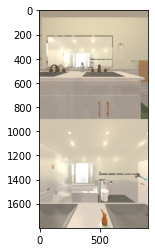

In [63]:
camera_position = {
    'position': {'x': -1.3581395149230957,
   'y': 1.5946828126907349,
   'z': 3.151395082473755},
    'rotation': {
        'x':0,
        'y':0,
        'z':0
    }
}
controller.reset('FloorPlan403')
setup_thirdparty_camera(controller, camera_position)

controller.step(
    action="MoveArmBase",
    y=0.5,
    speed=1,
    returnToStart=True,
    fixedDeltaTime=0.02
)
controller.step('Pass')
controller.step(
    action="MoveArmBase",
    y=1,
    speed=1,
    returnToStart=True,
    fixedDeltaTime=0.02
)
controller.step(
    action="MoveArm",
    position=dict(x=0, y=0, z=1),
    coordinateSpace="armBase",
    restrictMovement=False,
    speed=1,
    returnToStart=True,
    fixedDeltaTime=0.02
)

visualize(controller, True)

In [60]:
plt.imsave('/Users/kianae/Desktop/visualize.png', combined)